<a href="https://colab.research.google.com/github/imviswa4u/MScFE_Capstone_1158/blob/module4_code_draft1/draft_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Going as per our Pseudo Code

## Step 1 - Importing relevant libraries

In [9]:
pip install quandl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
pip install fredapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import pandas as pd
import numpy as np
import scipy as sp
import quandl

from fredapi import Fred
from datetime import datetime
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA as PCA

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# QUANDL API Key
quandl.ApiConfig.api_key = "45xv1xG1X3aWTLZ1oRcp"


# FRED API key
fred_key = "02e42817b0bcd1d7e7ee373eea6365c0"
fred = Fred(api_key=fred_key)

## Step 2 - Defined Functions

In [13]:
def mPCA(df, num_reconstruct):
    
    df -= df.mean(axis=0)
    R = np.cov(df, rowvar=False)
    eigenvals, eigenvecs = sp.linalg.eigh(R)
    eigenvecs = eigenvecs[:, np.argsort(eigenvals)[::-1]]
    eigenvals = eigenvals[np.argsort(eigenvals)[::-1]]
    eigenvecs = eigenvecs[:, :num_reconstruct]

    return np.dot(eigenvecs.T, df.T).T, eigenvals, eigenvecs

In [70]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA


class PCABase(object):
    def __init__(self, X, adjust_sign=True):
        self.X = X
        self.n_features = X.shape[1]
        self.dates = X.index
        self.Xc = self.X - self.X.mean()  # centered
        self.pc_names = lambda n: ['PC' + str(i) for i in np.arange(1, n + 1)]
        self.adjust_sign = adjust_sign


    def pca(self, n_pc=None):
        '''
        fit pca model
        n_pc: number of pcs to fit, take total feature numbers if not specified
        '''
        if n_pc:
            model = PCA(n_components=n_pc).fit(self.Xc)
        else:
            model = PCA().fit(self.Xc)
        return model

    def cps(self):
        '''
        loading matrix => principal axes in feature space
        '''
        cps = self.pca().components_.T
        cps = self.to_df_pc(cps, is_loading=True)
        if self.adjust_sign:
            cps.loc[:, 'PC1'] = np.sign(cps.loc[:, 'PC1'].values[0]) * cps.loc[:, 'PC1']
            cps.loc[:, 'PC2'] = -np.sign(cps.loc[:, 'PC2'].values[0]) * cps.loc[:, 'PC2']
        return cps

    def cumsum_expvar_ratio(self):
        var_exp = self.pca().explained_variance_ratio_
        var_exp_cumsum = np.cumsum(var_exp)
        return var_exp, var_exp_cumsum

    def scores(self):
        '''
        PC scores:
        '''
        scores = self.pca().transform(self.Xc)
        scores = self.to_df_pc(scores)
        if self.adjust_sign:
            cps = self.cps()
            scores.loc[:, 'PC1'] = np.sign(cps.loc[:, 'PC1'].values[0]) * scores.loc[:, 'PC1']
            scores.loc[:, 'PC2'] = -np.sign(cps.loc[:, 'PC2'].values[0]) * scores.loc[:, 'PC2']
        return scores

    def scores2(self):
        '''
        equivalent to the sklearn transform function
        '''
        scores = self.Xc.dot(self.cps())
        scores = self.to_df_pc(scores)
        if self.adjust_sign:
            cps = self.cps()
            scores.loc[:, 'PC1'] = np.sign(cps.loc[:, 'PC1'].values[0]) * scores.loc[:, 'PC1']
            scores.loc[:, 'PC2'] = -np.sign(cps.loc[:, 'PC2'].values[0]) * scores.loc[:, 'PC2']
        return scores

    def x_projected(self, p, centered=False):
        xp = self.scores().iloc[:, 0:p].dot(self.cps().T.iloc[0:p, :])
        if not centered:
            xp = xp + self.X.mean()
        return xp

    def residuals(self, p):
        residuals = self.X - self.x_projected(p, centered=False)
        return residuals

    def covX(self):
        return self.X.cov()

    def eigenv(self):
        eig_vals, eig_vecs = np.linalg.eig(self.covX())
        return eig_vals, eig_vecs

    def to_df_pc(self, data, is_loading=False):
        cols = self.pc_names(self.n_features)
        idx = self.X.columns if is_loading else self.dates
        return pd.DataFrame(data, columns=cols, index=idx)

## Step 3 - Importing datasets

### First - Swap rates data

In [14]:
swap_names = ['FRED/DSWP1', 
             'FRED/DSWP2', 
             'FRED/DSWP3', 
             'FRED/DSWP4', 
             'FRED/DSWP5', 
             'FRED/DSWP7', 
             'FRED/DSWP10', 
             'FRED/DSWP30']

swap_df = quandl.get(swap_names)
swap_df = swap_df.dropna()
swap_df.columns = ["SWAP1",
                  "SWAP2",
                  "SWAP3",
                  "SWAP4",
                  "SWAP5",
                  "SWAP7",
                  "SWAP10",
                  "SWAP30"]

cols = ["SWAP1",
        "SWAP2",
        "SWAP3",
        "SWAP5",
        "SWAP7",
        "SWAP10"]


In [15]:
swap_df.head()

,SWAP1,SWAP2,SWAP3,SWAP4,SWAP5,SWAP7,SWAP10,SWAP30
DATE,,,,,,,,
2000-07-03,7.10,7.16,7.17,7.17,7.17,7.20,7.24,7.24
2000-07-05,7.03,7.06,7.07,7.07,7.08,7.11,7.14,7.16
2000-07-06,7.07,7.13,7.14,7.15,7.16,7.19,7.21,7.21
2000-07-07,7.01,7.04,7.06,7.06,7.07,7.10,7.14,7.14
2000-07-10,7.04,7.09,7.11,7.13,7.14,7.17,7.20,7.19


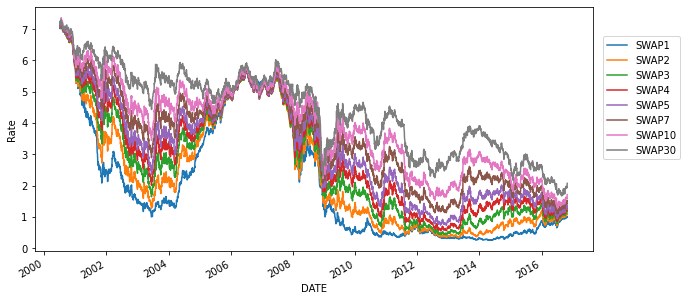

In [16]:
swap_df.plot(figsize=(10,5))
plt.ylabel("Rate")
plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2)
plt.show()

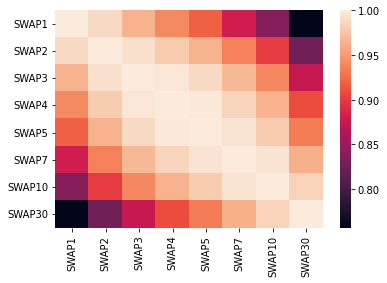

In [17]:
sns.heatmap(swap_df.corr())
plt.show()

In [18]:
swap_df2 = swap_df.copy()
swap_df2 = swap_df2.loc[:, ]

### Second - Treasury rates data

In [19]:
treasury = ['FRED/DGS1MO',
           'FRED/DGS3MO',
           'FRED/DGS6MO',
           'FRED/DGS1',
           'FRED/DGS2',
           'FRED/DGS3',
           'FRED/DGS5',
           'FRED/DGS7',
           'FRED/DGS10',
           'FRED/DGS20',
           'FRED/DGS30']

treasury_df = quandl.get(treasury)
treasury_df.columns = ['TRESY1mo',
                    'TRESY3mo', 
                    'TRESY6mo',
                    'TRESY1y',
                    'TRESY2y',
                    'TRESY3y',
                    'TRESY5y',
                    'TRESY7y',
                    'TRESY10y',
                    'TRESY20y',
                    'TRESY30y']

col = ['TRESY1y',
                    'TRESY2y',
                    'TRESY3y',
                    'TRESY5y',
                    'TRESY7y',
                    'TRESY10y']

In [20]:
treasury_df.head()

,TRESY1mo,TRESY3mo,TRESY6mo,TRESY1y,TRESY2y,TRESY3y,TRESY5y,TRESY7y,TRESY10y,TRESY20y,TRESY30y
Date,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,3.22,NaN,3.70,3.88,NaN,4.06,4.07,NaN
1962-01-03,NaN,NaN,NaN,3.24,NaN,3.70,3.87,NaN,4.03,4.07,NaN
1962-01-04,NaN,NaN,NaN,3.24,NaN,3.69,3.86,NaN,3.99,4.06,NaN
1962-01-05,NaN,NaN,NaN,3.26,NaN,3.71,3.89,NaN,4.02,4.07,NaN
1962-01-08,NaN,NaN,NaN,3.31,NaN,3.71,3.91,NaN,4.03,4.08,NaN


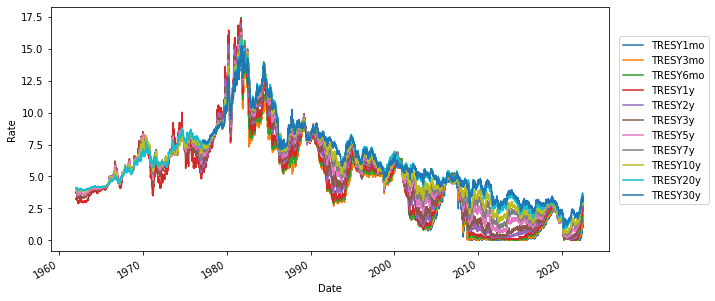

In [21]:
treasury_df.plot(figsize=(10,5))
plt.ylabel("Rate")
plt.legend(bbox_to_anchor=(1.01,.9), loc=2)
plt.show()

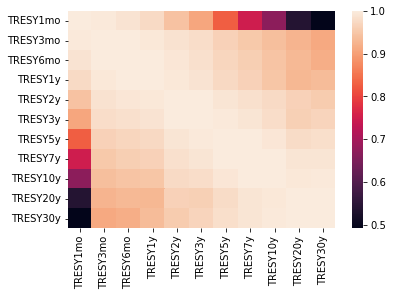

In [22]:
sns.heatmap(treasury_df.corr())
plt.show()

In [23]:
treasury_df

,TRESY1mo,TRESY3mo,TRESY6mo,TRESY1y,TRESY2y,TRESY3y,TRESY5y,TRESY7y,TRESY10y,TRESY20y,TRESY30y
Date,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,3.22,NaN,3.70,3.88,NaN,4.06,4.07,NaN
1962-01-03,NaN,NaN,NaN,3.24,NaN,3.70,3.87,NaN,4.03,4.07,NaN
1962-01-04,NaN,NaN,NaN,3.24,NaN,3.69,3.86,NaN,3.99,4.06,NaN
1962-01-05,NaN,NaN,NaN,3.26,NaN,3.71,3.89,NaN,4.02,4.07,NaN
1962-01-08,NaN,NaN,NaN,3.31,NaN,3.71,3.91,NaN,4.03,4.08,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-11,1.58,2.18,2.79,2.97,3.07,3.09,3.05,3.06,2.99,3.43,3.18
2022-07-12,1.63,2.22,2.78,3.07,3.03,3.07,3.01,3.01,2.96,3.37,3.13
2022-07-13,1.78,2.39,2.96,3.21,3.13,3.14,3.02,3.00,2.91,3.35,3.08


In [24]:
treasury_df2 = treasury_df.loc[:, col]
treasury_df2 = treasury_df2.dropna()
combined_df = treasury_df2.merge(swap_df2, left_index=True, right_index=True)
combined_df

,TRESY1y,TRESY2y,TRESY3y,TRESY5y,TRESY7y,TRESY10y,SWAP1,SWAP2,SWAP3,SWAP4,SWAP5,SWAP7,SWAP10,SWAP30
2000-07-03,6.07,6.31,6.24,6.12,6.19,6.00,7.10,7.16,7.17,7.17,7.17,7.20,7.24,7.24
2000-07-05,6.06,6.29,6.23,6.12,6.18,5.99,7.03,7.06,7.07,7.07,7.08,7.11,7.14,7.16
2000-07-06,6.10,6.34,6.28,6.16,6.24,6.05,7.07,7.13,7.14,7.15,7.16,7.19,7.21,7.21
2000-07-07,6.07,6.29,6.23,6.11,6.17,6.01,7.01,7.04,7.06,7.06,7.07,7.10,7.14,7.14
2000-07-10,6.09,6.31,6.24,6.13,6.21,6.04,7.04,7.09,7.11,7.13,7.14,7.17,7.20,7.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-10-24,0.66,0.84,1.00,1.27,1.56,1.77,0.99,1.08,1.15,1.22,1.30,1.43,1.61,1.96
2016-10-25,0.66,0.86,1.00,1.29,1.56,1.77,1.00,1.08,1.15,1.22,1.29,1.42,1.59,1.93
2016-10-26,0.67,0.86,1.01,1.30,1.59,1.79,1.01,1.10,1.18,1.25,1.33,1.47,1.64,1.98
2016-10-27,0.68,0.87,1.04,1.33,1.64,1.85,1.00,1.11,1.20,1.29,1.38,1.53,1.71,2.07


Also importing the U.S. Treasury Maturity Rate.

In [25]:
startDate = '2000-01-01'
endDate = '2023-01-01'
df = []
ids = ['DGS{}'.format(i) for i in ['1MO', '3MO', '6MO', 1,2,5,7,10,20,30]]
for s in ids:
    df.append(fred.get_series(s, observation_start=startDate, observation_end=endDate)/100)
  
df = pd.concat(df,axis=1)
df.columns = ids
maturity_df = df.dropna()

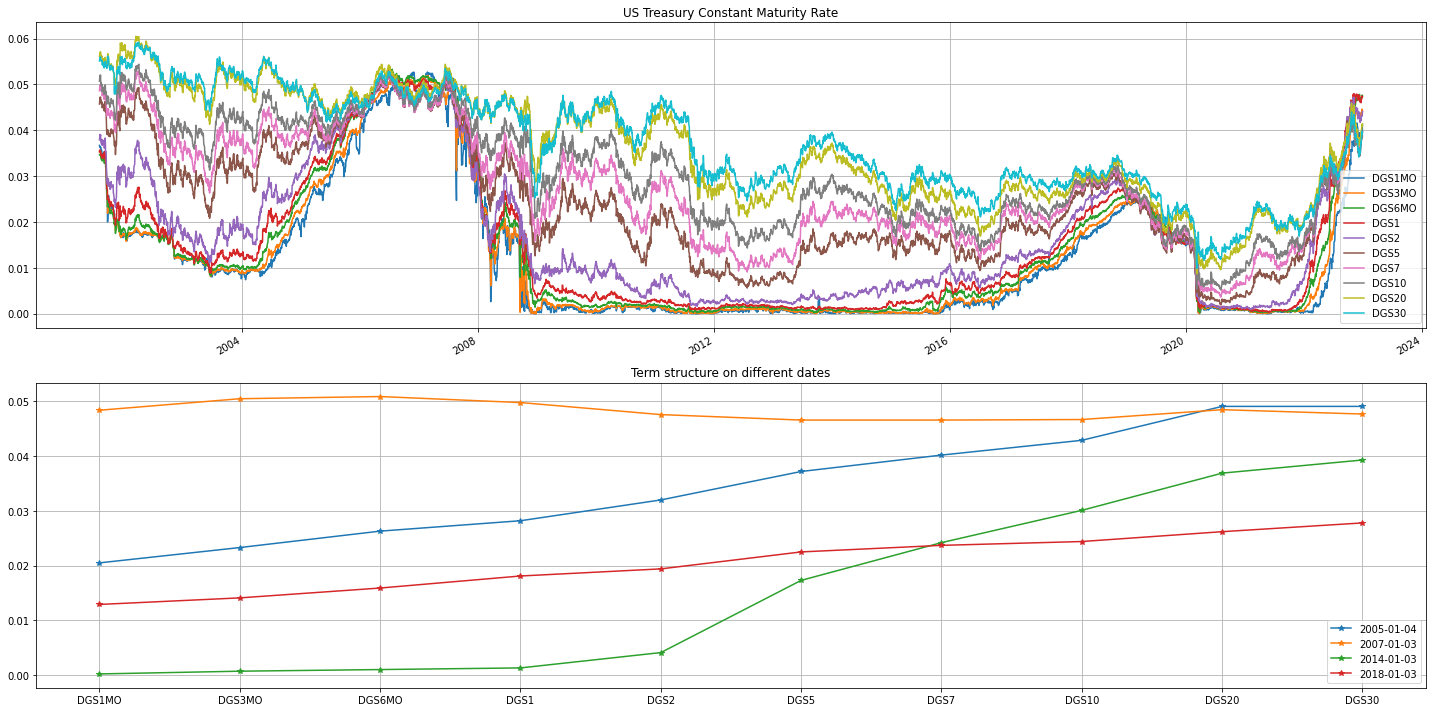

In [26]:
fig,(ax,ax2)=plt.subplots(nrows=2,ncols=1,figsize=(20,5*2))
maturity_df.plot(grid=True,title='US Treasury Constant Maturity Rate',ax=ax)
x = maturity_df.loc[[datetime(2005,1,4),datetime(2007,1,3),datetime(2014,1,3),datetime(2018,1,3)],:]
x.index = [t.date() for t in x.index]
ax.legend(loc='lower right')
ax2.plot(x.T.index,x.T,marker='*')
ax2.legend(x.index, loc='lower right')
ax2.grid(True)
ax2.set_title('Term structure on different dates')
fig.tight_layout()

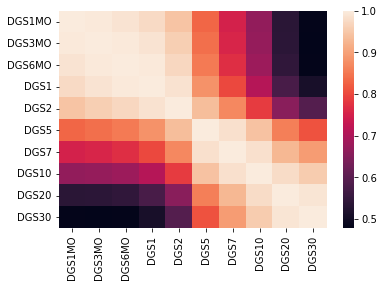

In [27]:
sns.heatmap(maturity_df.corr())
plt.show()

### Third - Spread rate data

In [28]:
spread = [combined_df.SWAP1-combined_df.TRESY1y, 
        combined_df.SWAP2-combined_df.TRESY2y,
       combined_df.SWAP3-combined_df.TRESY3y,
       combined_df.SWAP5-combined_df.TRESY5y,
       combined_df.SWAP7-combined_df.TRESY7y,
       combined_df.SWAP10-combined_df.TRESY10y]
spread_df = pd.DataFrame(np.array(spread).T, index=combined_df.index, 
                         columns = ["SPREAD1y", "SPREAD2y", "SPREAD3y", "SPREAD5y", "SPREAD7y", "SPREAD10y"])

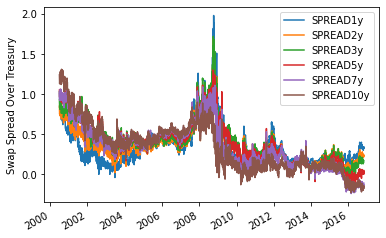

In [29]:
spread_df.plot()
plt.ylabel("Swap Spread Over Treasury")
plt.show()

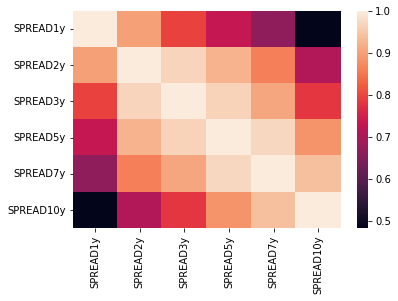

In [30]:
sns.heatmap(spread_df.corr())
plt.show()

## Step 4 - Cleaning Data

In [31]:
swap_df.isnull().sum()

SWAP1     0
SWAP2     0
SWAP3     0
SWAP4     0
SWAP5     0
SWAP7     0
SWAP10    0
SWAP30    0
dtype: int64

In [32]:
treasury_df2.isnull().sum()

TRESY1y     0
TRESY2y     0
TRESY3y     0
TRESY5y     0
TRESY7y     0
TRESY10y    0
dtype: int64

In [33]:
spread_df.isnull().sum()

SPREAD1y     0
SPREAD2y     0
SPREAD3y     0
SPREAD5y     0
SPREAD7y     0
SPREAD10y    0
dtype: int64

We can see that there are no outliers nor null values. So, the data is clean.

In [34]:
swap_df2.describe()

,SWAP1,SWAP2,SWAP3,SWAP4,SWAP5,SWAP7,SWAP10,SWAP30
count,4078.000000,4078.000000,4078.000000,4078.000000,4078.000000,4078.000000,4078.000000,4078.000000
mean,2.105755,2.390218,2.688190,2.953082,3.181395,3.534772,3.872545,4.394841
std,1.913386,1.832076,1.765902,1.699581,1.636723,1.534743,1.445819,1.331056
min,0.250000,0.340000,0.420000,0.560000,0.730000,1.100000,1.280000,1.670000
25%,0.490000,0.780000,1.060000,1.370000,1.660000,2.140000,2.552500,3.190000
50%,1.330000,1.800000,2.310000,2.770000,3.125000,3.610000,4.070000,4.620000
75%,3.507500,3.920000,4.197500,4.450000,4.580000,4.830000,5.020000,5.390000
max,7.130000,7.220000,7.250000,7.270000,7.290000,7.320000,7.360000,7.300000


In [35]:
treasury_df2.describe()

,TRESY1y,TRESY2y,TRESY3y,TRESY5y,TRESY7y,TRESY10y
count,11528.000000,11528.000000,11528.000000,11528.000000,11528.000000,11528.000000
mean,4.729735,5.023472,5.198956,5.515355,5.766339,5.948340
std,3.833076,3.803110,3.718687,3.570421,3.455406,3.335662
min,0.040000,0.090000,0.100000,0.190000,0.360000,0.520000
25%,1.240000,1.540000,1.690000,2.340000,2.780000,3.010000
50%,4.770000,4.860000,4.935000,5.220000,5.510000,5.610000
75%,6.980000,7.480000,7.660000,7.830000,7.990000,8.090000
max,17.310000,16.950000,16.590000,16.270000,16.050000,15.840000


In [36]:
spread_df.describe()

,SPREAD1y,SPREAD2y,SPREAD3y,SPREAD5y,SPREAD7y,SPREAD10y
count,4078.000000,4078.000000,4078.000000,4078.000000,4078.000000,4078.000000
mean,0.344640,0.366984,0.408210,0.395076,0.351932,0.337499
std,0.238055,0.228002,0.257108,0.267024,0.278854,0.301934
min,-0.040000,0.020000,-0.040000,-0.140000,-0.240000,-0.230000
25%,0.180000,0.200000,0.210000,0.170000,0.130000,0.100000
50%,0.260000,0.330000,0.390000,0.390000,0.350000,0.340000
75%,0.430000,0.440000,0.500000,0.520000,0.520000,0.540000
max,1.980000,1.690000,1.720000,1.300000,1.110000,1.310000


## Step 5 - Visualizing Data

### Box - Plot

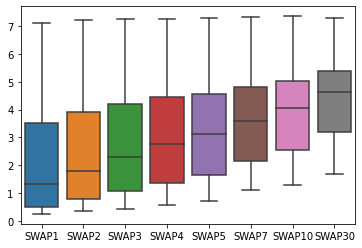

In [37]:
sns.boxplot(data=swap_df)

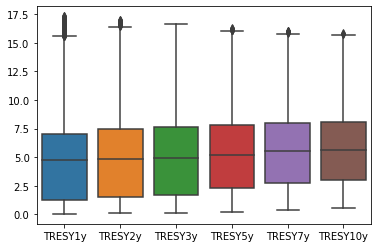

In [38]:
sns.boxplot(data=treasury_df2)

### Skewness - Kurtosis

,Median price,Mean price,Mean vs. Median price,Skewness,Kurtosis
SPREAD1y,0.26,0.34,0.08,1.98,5.44
SPREAD2y,0.33,0.37,0.04,1.46,2.83
SPREAD3y,0.39,0.41,0.02,1.09,1.62
SPREAD5y,0.39,0.40,0.01,0.56,-0.14
SPREAD7y,0.35,0.35,0.00,0.34,-0.42
SPREAD10y,0.34,0.34,-0.00,0.59,0.01


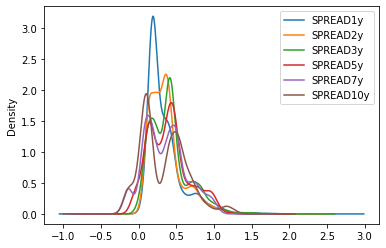

In [39]:
spread_df.plot(kind = 'density')
all = pd.DataFrame()
all['Median price'] = spread_df.median()
all['Mean price'] = spread_df.mean()
all['Mean vs. Median price'] = all['Mean price'] - all['Median price']
all['Skewness'] = spread_df.skew()
all['Kurtosis'] = spread_df.kurt()
all.round(2)

### Histogram Plot

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


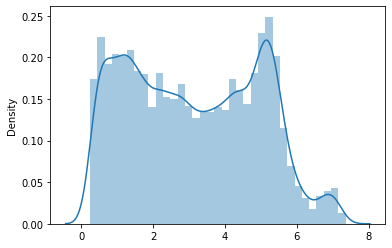

In [40]:
sns.distplot(swap_df)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


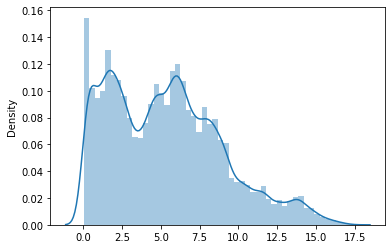

In [41]:
sns.distplot(treasury_df2)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


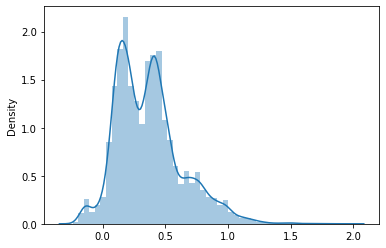

In [42]:
sns.distplot(spread_df)

## Step 6 - Apply PCA to data

### PCA to Swap dataset

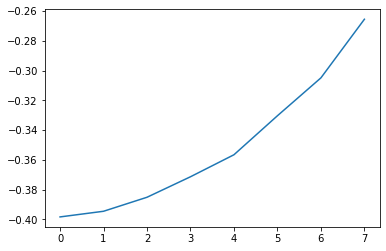

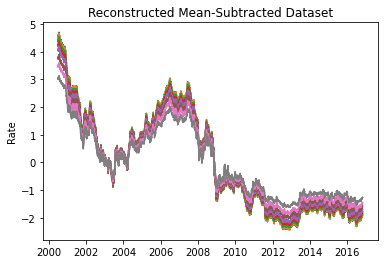

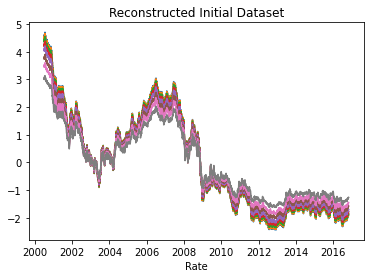

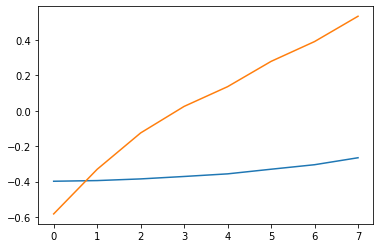

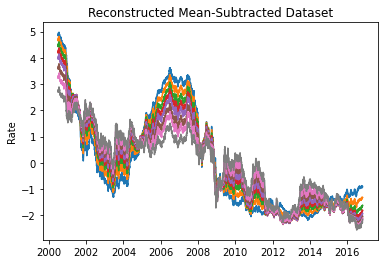

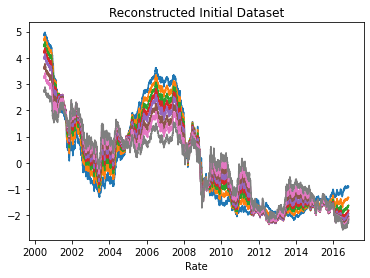

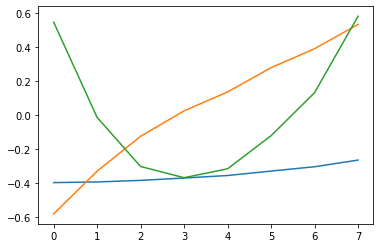

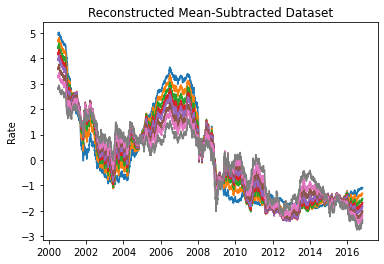

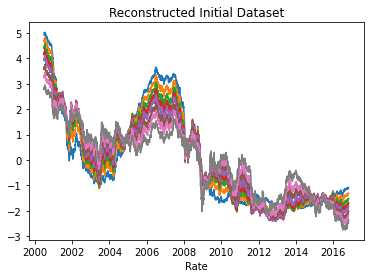

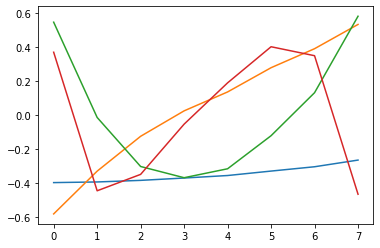

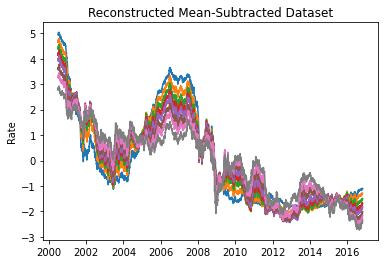

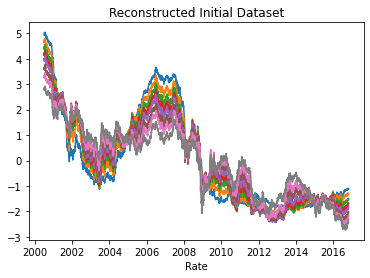

In [63]:
vec = [1,2,3,4]

for i in vec:
  scores, evals, evecs = mPCA(swap_df, i)
  evecs = pd.DataFrame(evecs)
  plt.plot(evecs)
  plt.show()
  reconst = pd.DataFrame(np.dot(scores,evecs.T), index=swap_df.index, columns=swap_df.columns)
  plt.plot(reconst)
  plt.ylabel("Rate")
  plt.title("Reconstructed Mean-Subtracted Dataset")
  plt.show()
  for cols in reconst.columns:
    reconst[cols] = reconst[cols] + swap_df2.mean(axis=0)[cols]
  plt.plot(reconst)
  plt.xlabel("Rate")
  plt.title("Reconstructed Initial Dataset")
  plt.show()

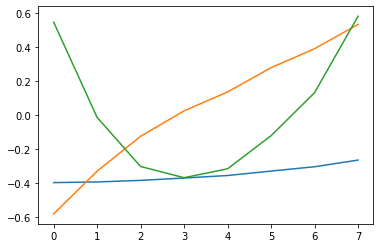

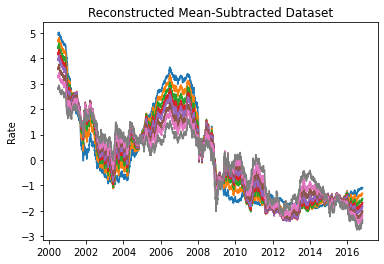

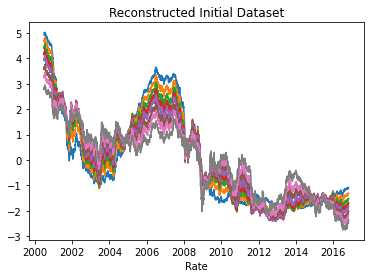

In [65]:
vec = 3
scores, evals, evecs = mPCA(swap_df, vec)
evecs = pd.DataFrame(evecs)
plt.plot(evecs)
plt.show()
reconst = pd.DataFrame(np.dot(scores,evecs.T), index=swap_df.index, columns=swap_df.columns)
plt.plot(reconst)
plt.ylabel("Rate")
plt.title("Reconstructed Mean-Subtracted Dataset")
plt.show()
for cols in reconst.columns:
  reconst[cols] = reconst[cols] + swap_df2.mean(axis=0)[cols]
plt.plot(reconst)
plt.xlabel("Rate")
plt.title("Reconstructed Initial Dataset")
def PCA(df, num_reconstruct):
    
    df -= df.mean(axis=0)
    R = np.cov(df, rowvar=False)
    eigenvals, eigenvecs = sp.linalg.eigh(R)
    eigenvecs = eigenvecs[:, np.argsort(eigenvals)[::-1]]
    eigenvals = eigenvals[np.argsort(eigenvals)[::-1]]
    eigenvecs = eigenvecs[:, :num_reconstruct]

    return np.dot(eigenvecs.T, df.T).T, eigenvals, eigenvecsplt.show()

### PCA to Treasury dataset

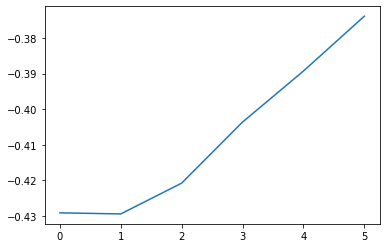

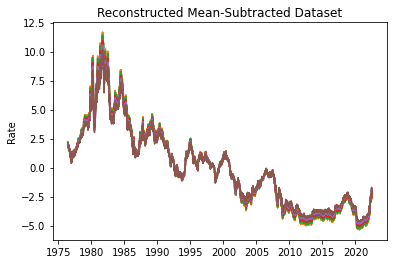

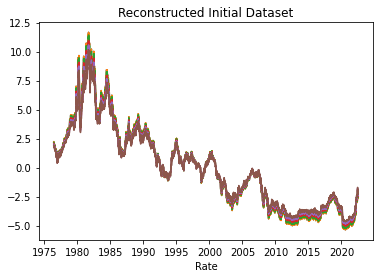

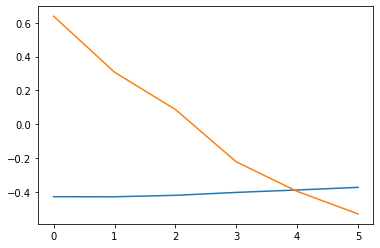

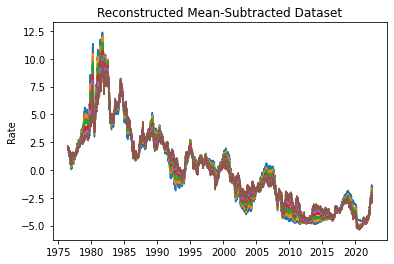

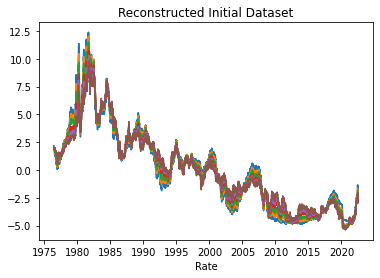

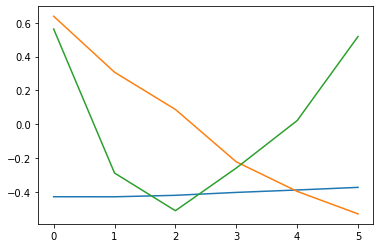

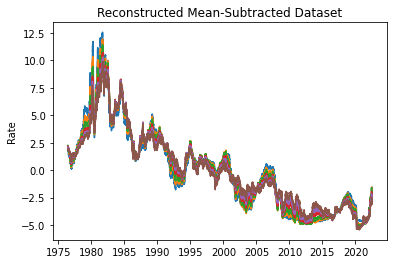

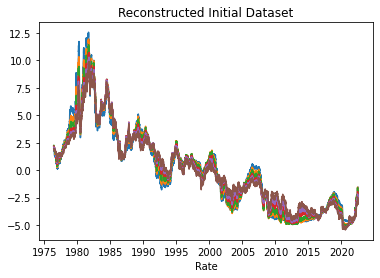

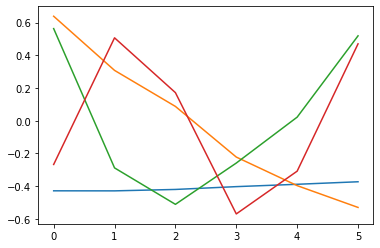

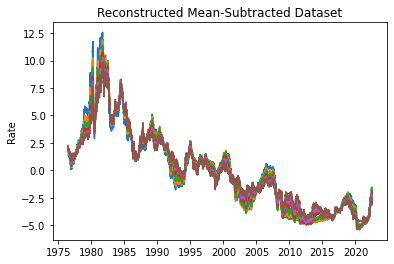

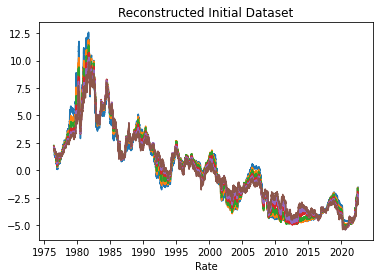

In [67]:
vec = [1,2,3,4]
comb_df = treasury_df2.merge(swap_df2, left_index=True, right_index=True)

for i in vec:
  scores, evals, evecs = mPCA(treasury_df2, i)
  evecs = pd.DataFrame(evecs)
  plt.plot(evecs)
  plt.show()
  reconst = pd.DataFrame(np.dot(scores,evecs.T), index=treasury_df2.index, columns=treasury_df2.columns)
  plt.plot(reconst)
  plt.ylabel("Rate")
  plt.title("Reconstructed Mean-Subtracted Dataset")
  plt.show()
  for cols in reconst.columns:
    reconst[cols] = reconst[cols] + treasury_df2.mean(axis=0)[cols]
  plt.plot(reconst)
  plt.xlabel("Rate")
  plt.title("Reconstructed Initial Dataset")
  plt.show()

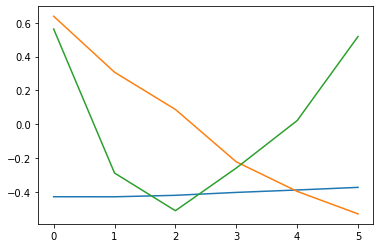

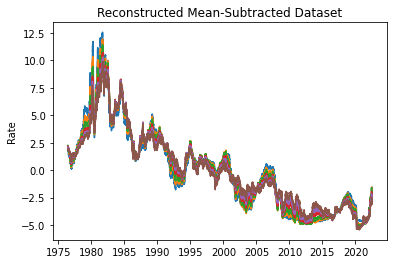

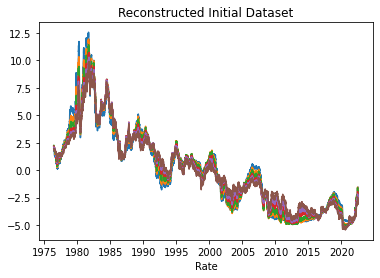

In [68]:
vec = 3
scores, evals, evecs = mPCA(treasury_df2, vec)
evecs = pd.DataFrame(evecs)
plt.plot(evecs)
plt.show()
reconst = pd.DataFrame(np.dot(scores,evecs.T), index=treasury_df2.index, columns=treasury_df2.columns)
plt.plot(reconst)
plt.ylabel("Rate")
plt.title("Reconstructed Mean-Subtracted Dataset")
plt.show()
for cols in reconst.columns:
  reconst[cols] = reconst[cols] + treasury_df2.mean(axis=0)[cols]
plt.plot(reconst)
plt.xlabel("Rate")
plt.title("Reconstructed Initial Dataset")
def PCA(df, num_reconstruct):
    
    df -= df.mean(axis=0)
    R = np.cov(df, rowvar=False)
    eigenvals, eigenvecs = sp.linalg.eigh(R)
    eigenvecs = eigenvecs[:, np.argsort(eigenvals)[::-1]]
    eigenvals = eigenvals[np.argsort(eigenvals)[::-1]]
    eigenvecs = eigenvecs[:, :num_reconstruct]

    return np.dot(eigenvecs.T, df.T).T, eigenvals, eigenvecsplt.show()

### PCA to Maturity Dataset

In [73]:
pcab = PCABase(maturity_df)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
DGS1MO,0.348263,-0.276252,-0.462781,-0.527567,-0.245677,0.285357,0.320182,0.241433,0.033638,0.078620
DGS3MO,0.358793,-0.286351,-0.295390,-0.090388,0.132740,-0.131109,-0.488484,-0.555608,-0.196110,-0.270665
DGS6MO,0.370574,-0.285464,-0.091990,0.318492,0.376007,-0.249524,-0.047514,0.189006,0.490260,0.435094
DGS1,0.368897,-0.240142,0.153742,0.427969,0.031749,-0.036064,0.231125,0.387814,-0.487415,-0.394654
DGS2,0.357064,-0.120232,0.458061,0.196579,-0.539500,0.257643,0.082092,-0.407112,0.091049,0.267163
DGS5,0.314622,0.162904,0.431002,-0.357320,-0.014589,-0.036525,-0.286383,0.274821,0.436769,-0.459542
DGS7,0.286417,0.271522,0.266321,-0.365133,0.187745,-0.172807,-0.160163,0.123595,-0.521023,0.512337
DGS10,0.261235,0.358744,0.011079,-0.087858,0.330211,-0.183320,0.660645,-0.418276,0.103940,-0.174244
DGS20,0.239413,0.480436,-0.227619,0.274527,0.230731,0.697569,-0.206045,0.047092,0.009071,0.009699
DGS30,0.206134,0.477804,-0.384755,0.214897,-0.539292,-0.469078,-0.099388,0.114765,0.032771,-0.001327


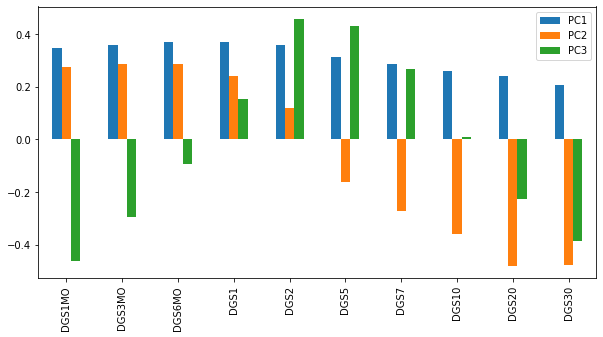

In [74]:
# loading matrix (direction may change but doesn't matter)
V = pd.DataFrame(pcab.pca().components_,index=pcab.pc_names(pcab.n_features),columns=pcab.X.columns)
V.T.iloc[:,0:3].plot(figsize=(10,5),kind='bar')
pcab.cps()

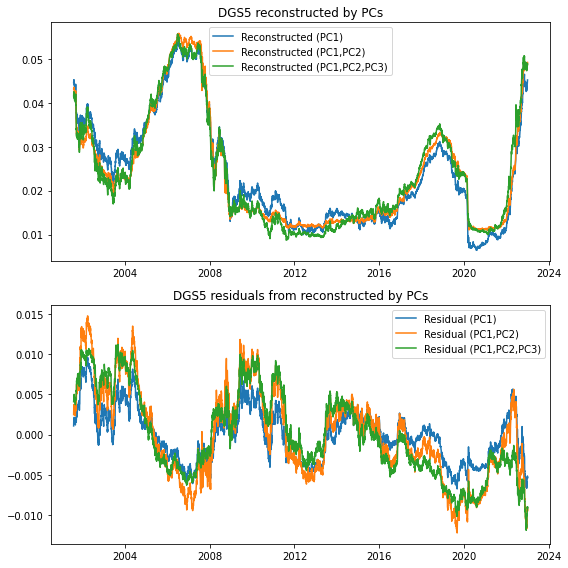

In [75]:
r = 'DGS5'
fig,(ax,ax2)=plt.subplots(figsize=(8,4*2),ncols=1,nrows=2)
ax.plot(pcab.x_projected(1)[r])
ax.plot(pcab.x_projected(2)[r])
ax.plot(pcab.x_projected(3)[r])
ax.legend(['Reconstructed (PC1)','Reconstructed (PC1,PC2)','Reconstructed (PC1,PC2,PC3)'])
ax.set_title('{} reconstructed by PCs'.format(r))

ax2.plot(pcab.residuals(1)[r])
ax2.plot(pcab.residuals(2)[r])
ax2.plot(pcab.residuals(3)[r])
ax2.legend(['Residual (PC1)','Residual (PC1,PC2)','Residual (PC1,PC2,PC3)'])
ax2.set_title('{} residuals from reconstructed by PCs'.format(r))
fig.tight_layout()

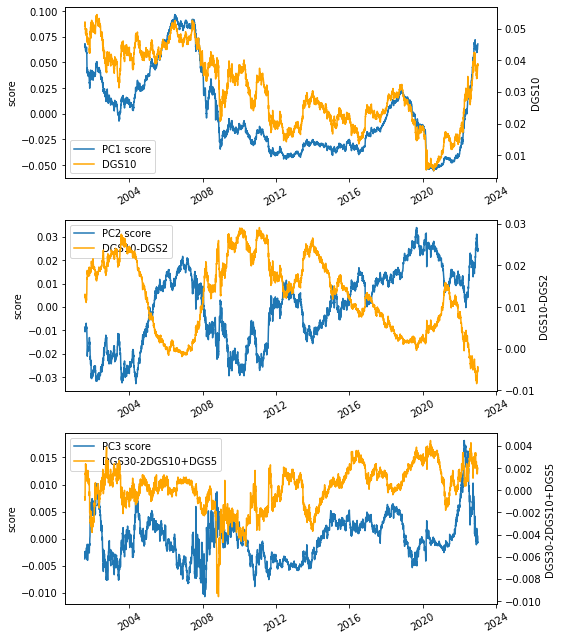

In [76]:
# PC Scores
fig,(ax1,ax2,ax3)=plt.subplots(nrows=3,ncols=1,figsize=(8,3*3))
l1=ax1.plot(pcab.scores()['PC1'])
ax12 = ax1.twinx()
l2=ax12.plot(pcab.X['DGS10'],color='orange')
ax1.tick_params('x',rotation=30)
ax1.legend(l1+l2,['PC1 score','DGS10'])
ax1.set_ylabel('score')
ax12.set_ylabel('DGS10')
# 
l1=ax2.plot(pcab.scores()['PC2'])
ax22 = ax2.twinx()
l2=ax22.plot(pcab.X['DGS10']-pcab.X['DGS2'],color='orange')
ax2.tick_params('x',rotation=30)
ax2.legend(l1+l2,['PC2 score','DGS10-DGS2'],loc='best')
ax2.set_ylabel('score')
ax22.set_ylabel('DGS10-DGS2')

# 
l1=ax3.plot(pcab.scores()['PC3'])
ax32 = ax3.twinx()
l2=ax32.plot(pcab.X['DGS30']-2*pcab.X['DGS10']+pcab.X['DGS5'],color='orange')
ax3.tick_params('x',rotation=30)
ax3.legend(l1+l2,['PC3 score','DGS30-2DGS10+DGS5'],loc='best')
ax3.set_ylabel('score')
ax32.set_ylabel('DGS30-2DGS10+DGS5')
fig.tight_layout()

Text(0.5, 1.0, 'Evolution of PCA Factors 1,2,3')

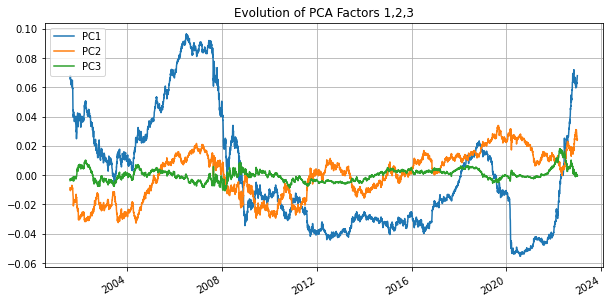

In [77]:
# PC
fig,ax=plt.subplots(figsize=(10,5))
l1=pcab.scores().iloc[:,0:3].plot(ax=ax)
ax.grid(True)
ax.set_title('Evolution of PCA Factors 1,2,3')

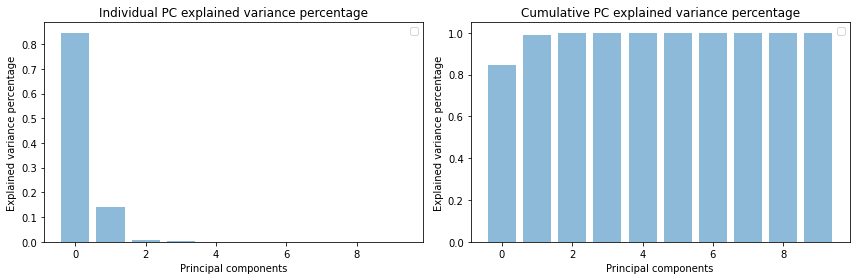

In [78]:
fig,(ax,ax2) = plt.subplots(figsize=(6*2, 4),ncols=2,nrows=1)
ax.bar(range(pcab.n_features), pcab.cumsum_expvar_ratio()[0], alpha=0.5, align='center')
ax2.bar(range(pcab.n_features), pcab.cumsum_expvar_ratio()[1], alpha=0.5, align='center')
ax.set_ylabel('Explained variance percentage')
ax.set_xlabel('Principal components')
ax.set_title('Individual PC explained variance percentage')
ax.legend(loc='best')
ax2.set_ylabel('Explained variance percentage')
ax2.set_xlabel('Principal components')
ax2.set_title('Cumulative PC explained variance percentage')
ax2.legend(loc='best')
fig.tight_layout()

### PCA to Spread dataset


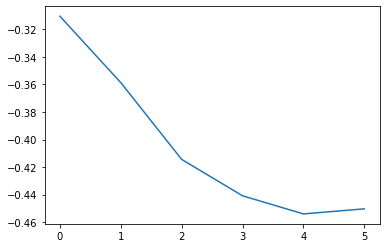

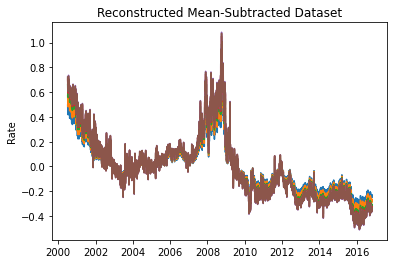

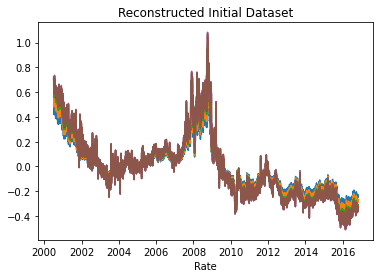

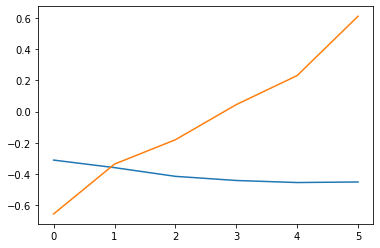

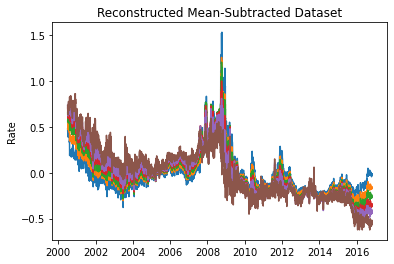

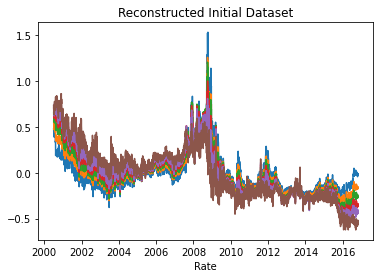

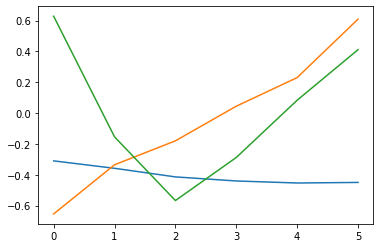

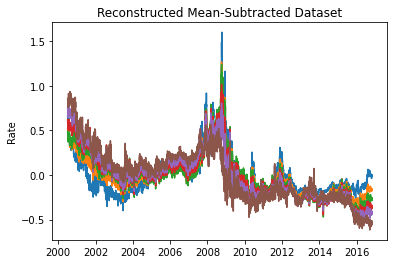

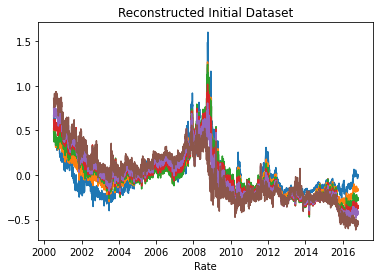

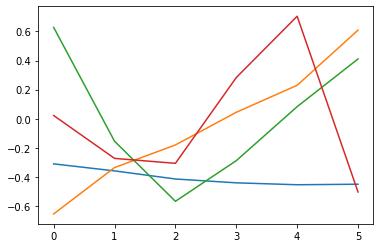

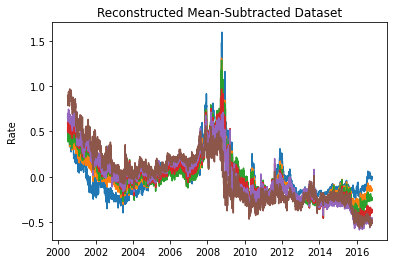

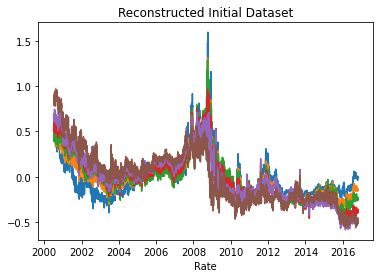

In [83]:
vec = [1,2,3,4]

for i in vec:
  scores, evals, evecs = mPCA(spread_df, i)
  evecs = pd.DataFrame(evecs)
  plt.plot(evecs)
  plt.show()
  reconst = pd.DataFrame(np.dot(scores,evecs.T), index=spread_df.index, columns=spread_df.columns)
  plt.plot(reconst)
  plt.ylabel("Rate")
  plt.title("Reconstructed Mean-Subtracted Dataset")
  plt.show()
  for cols in reconst.columns:
    reconst[cols] = reconst[cols] + spread_df.mean(axis=0)[cols]
  plt.plot(reconst)
  plt.xlabel("Rate")
  plt.title("Reconstructed Initial Dataset")
  plt.show()


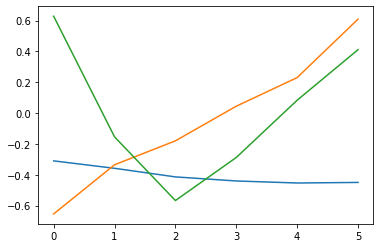

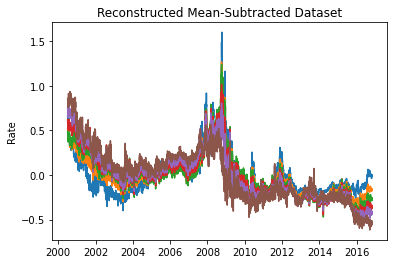

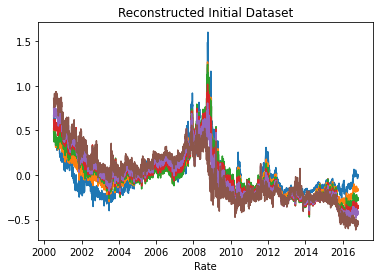

In [87]:
vec = 3
scores, evals, evecs = mPCA(spread_df, vec)
evecs = pd.DataFrame(evecs)
plt.plot(evecs)
plt.show()
reconst = pd.DataFrame(np.dot(scores,evecs.T), index=spread_df.index, columns=spread_df.columns)
plt.plot(reconst)
plt.ylabel("Rate")
plt.title("Reconstructed Mean-Subtracted Dataset")
plt.show()
for cols in reconst.columns:
  reconst[cols] = reconst[cols] + spread_df.mean(axis=0)[cols]
plt.plot(reconst)
plt.xlabel("Rate")
plt.title("Reconstructed Initial Dataset")
def PCA(df, num_reconstruct):
    
    df -= df.mean(axis=0)
    R = np.cov(df, rowvar=False)
    eigenvals, eigenvecs = sp.linalg.eigh(R)
    eigenvecs = eigenvecs[:, np.argsort(eigenvals)[::-1]]
    eigenvals = eigenvals[np.argsort(eigenvals)[::-1]]
    eigenvecs = eigenvecs[:, :num_reconstruct]

    return np.dot(eigenvecs.T, df.T).T, eigenvals, eigenvecsplt.show()

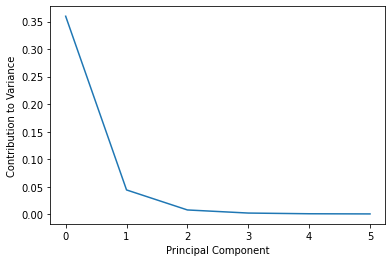

In [88]:
plt.plot(evals)
plt.ylabel("Contribution to Variance")
plt.xlabel("Principal Component")
plt.show()

## Step 7 - Applying Clustering to Treasury data

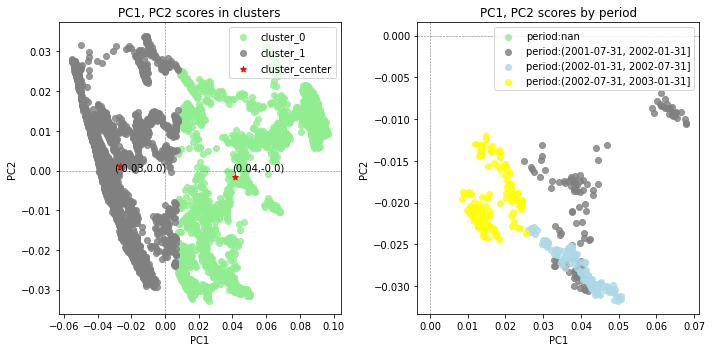

In [79]:
from sklearn.cluster import KMeans
def model_kmeans(data,n_clusters=3,init_method = 'k-means++',n_init=10):
  model = KMeans(n_clusters=n_clusters,
                  init=init_method,
                  n_init=n_init)
  model.fit(data)
  cluster_labels = model.predict(data)
  cluster_centers = model.cluster_centers_
  fit_res = {'cluster_method':'kmeans',
              'model':model,
              'cluster_labels':cluster_labels,
              'cluster_centers':cluster_centers,
              'data':data}
  return fit_res

s2 = pcab.scores()[['PC1','PC2']]
kmeans = model_kmeans(s2,n_clusters=2)  
X = s2.reset_index()
X = X.rename(columns={'index':'date'})

feature_pair = ['PC1','PC2']
fig,(ax,ax2)=plt.subplots(ncols=2,nrows=1,figsize=(10,5))
cluster_labels = kmeans['cluster_labels']
X['cluster_label'] = cluster_labels
cluster_centers = kmeans['cluster_centers']
mode_fitted = kmeans['model']
label_order = sorted(list(set(cluster_labels)))
colors = ['lightgreen','grey','lightblue','yellow']
# colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, [1,2,5,10])]
color_map_clusters = dict(zip(label_order, colors))
for (c_label,color) in color_map_clusters.items():
  x = X[X['cluster_label']==c_label][feature_pair[0]]
  y = X[X['cluster_label']==c_label][feature_pair[1]]
  ax.scatter(x,y,c=color,alpha=0.8)
ax.legend()
ax.scatter(cluster_centers[:,0],cluster_centers[:,1],c='red',marker='*')
# add cluster center annotion
for xy in tuple(np.round(cluster_centers,2)):
  ax.annotate("({},{})".format(xy[0],xy[1]),xy=(xy[0],xy[1]))
ax.set_xlabel(feature_pair[0])
ax.set_ylabel(feature_pair[1])
ax.legend(['cluster_{}'.format(c) for c in set(cluster_labels)]+['cluster_center'])
ax.set_title('PC1, PC2 scores in clusters')
ax.axhline(y=0,ls='--',color='grey',linewidth=0.6)
ax.axvline(x=0,ls='--',color='grey',linewidth=0.6)
# 
X['date'] = pd.to_datetime(X['date'])
periods = pd.date_range(X['date'].iloc[0]-pd.Timedelta(days=3),X['date'].iloc[-1],freq='6M')
X['date_bucket'] = pd.cut(X['date'],bins=periods)
color_map_periods = dict(zip(X['date_bucket'].unique(), colors))
for (p_label,color) in color_map_periods.items():
  x = X[X['date_bucket']==p_label][feature_pair[0]]
  y = X[X['date_bucket']==p_label][feature_pair[1]]
  ax2.scatter(x,y,c=color,alpha=0.8)
ax2.legend()

ax2.set_xlabel(feature_pair[0])
ax2.set_ylabel(feature_pair[1])
ax2.set_title('PC1, PC2 scores by period')
ax2.legend(['period:{}'.format(c) for c in X['date_bucket'].unique()])
ax2.axhline(y=0,ls='--',color='grey',linewidth=0.6)
ax2.axvline(x=0,ls='--',color='grey',linewidth=0.6)
fig.tight_layout()

## Futher steps to follow from pseudo code in coming modules